## Package and setup

In [37]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import RandomForestModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mae, r2_score
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


COLORS = {
    'IHSG': '#2E7D32',           # Green (primary)
    'IHSG_light': '#4CAF50',
    'IHSG_dark': '#1B5E20',    
    'STI': '#1976D2',            # Blue for regional index
    'Gold': '#FFD700',           # Gold color
    'Coal': '#FF5722',           # Orange-red
    'Copper': '#795548',         # Brown
    'Silver': '#9E9E9E',         # Gray
    'Tin': '#607D8B',            # Blue-gray
    'Nickel': '#FF9800',         # Orange
    'train': '#2E7D32',
    'actual': '#1976D2',
    'predicted': '#D32F2F',
    'error': '#9E9E9E',
    'split_line': '#616161',
}

COLOR_PALETTE = ['#2E7D32', '#D32F2F', '#F57C00', '#1976D2', '#7B1FA2', '#C2185B', '#FFD700']

# =========================================================================
# MATPLOTLIB THESIS STYLE
# =========================================================================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100          # Display DPI
plt.rcParams['savefig.dpi'] = 300         # Export DPI (publication quality)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# Font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Georgia']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Line settings
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 0.8

# Grid settings
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5

# Legend settings
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.edgecolor'] = '0.8'

print("Libraries imported successfully!")
print("Thesis color palette and matplotlib style configured.")

Libraries imported successfully!
Thesis color palette and matplotlib style configured.


## 2. Load and Merge Data

In [38]:
# Load all datasets
print("="*60)
print("LOADING DATASETS")
print("="*60)

# IHSG (target) - Indonesian format dd/mm/yyyy
ihsg = pd.read_csv('dataset/ihsg_daily.csv')
ihsg['Date'] = pd.to_datetime(ihsg['Date'], format='%d/%m/%Y')
ihsg.columns = ['Date', 'IHSG']
print(f"IHSG: {len(ihsg)} rows, {ihsg['Date'].min()} to {ihsg['Date'].max()}")

# STI - Indonesian format dd/mm/yyyy
sti = pd.read_csv('dataset/STI.csv')
sti['Date'] = pd.to_datetime(sti['Date'], format='%d/%m/%Y')
sti.columns = ['Date', 'STI']
print(f"STI: {len(sti)} rows, {sti['Date'].min()} to {sti['Date'].max()}")

# Gold - Indonesian format dd/mm/yyyy
gold = pd.read_csv('dataset/Gold.csv')
gold['Date'] = pd.to_datetime(gold['Date'], format='%d/%m/%Y')
gold.columns = ['Date', 'Gold']
print(f"Gold: {len(gold)} rows, {gold['Date'].min()} to {gold['Date'].max()}")

# Commodities - US format mm/dd/yyyy
coal = pd.read_csv('dataset/Coal.csv')
coal['Date'] = pd.to_datetime(coal['Date'], format='%m/%d/%Y')
coal.columns = ['Date', 'Coal']
print(f"Coal: {len(coal)} rows, {coal['Date'].min()} to {coal['Date'].max()}")

copper = pd.read_csv('dataset/Copper.csv')
copper['Date'] = pd.to_datetime(copper['Date'], format='%m/%d/%Y')
copper.columns = ['Date', 'Copper']
print(f"Copper: {len(copper)} rows, {copper['Date'].min()} to {copper['Date'].max()}")

silver = pd.read_csv('dataset/Silver.csv')
silver['Date'] = pd.to_datetime(silver['Date'], format='%m/%d/%Y')
silver.columns = ['Date', 'Silver']
print(f"Silver: {len(silver)} rows, {silver['Date'].min()} to {silver['Date'].max()}")

tin = pd.read_csv('dataset/Tin.csv')
tin['Date'] = pd.to_datetime(tin['Date'], format='%m/%d/%Y')
tin.columns = ['Date', 'Tin']
print(f"Tin: {len(tin)} rows, {tin['Date'].min()} to {tin['Date'].max()}")

nickel = pd.read_csv('dataset/Nickel.csv')
nickel['Date'] = pd.to_datetime(nickel['Date'], format='%m/%d/%Y')
nickel.columns = ['Date', 'Nickel']
print(f"Nickel: {len(nickel)} rows, {nickel['Date'].min()} to {nickel['Date'].max()}")

LOADING DATASETS
IHSG: 2660 rows, 2015-01-02 00:00:00 to 2025-12-30 00:00:00
STI: 2766 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Gold: 2857 rows, 2015-01-01 00:00:00 to 2025-12-31 00:00:00
Coal: 2839 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Copper: 2780 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Silver: 2857 rows, 2015-01-01 00:00:00 to 2025-12-31 00:00:00
Tin: 2780 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Nickel: 2774 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00


In [39]:
# Merge all datasets on Date (inner join to get common dates)
print("\n" + "="*60)
print("MERGING DATASETS")
print("="*60)

# Start with IHSG as base
df = ihsg.copy()

# Merge each dataset (Gold added)
for dataset, name in [(sti, 'STI'), (gold, 'Gold'), (coal, 'Coal'), (copper, 'Copper'), 
                       (silver, 'Silver'), (tin, 'Tin'), (nickel, 'Nickel')]:
    df = df.merge(dataset, on='Date', how='inner')
    print(f"After merging {name}: {len(df)} rows")

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

print(f"\n✅ Final merged dataset: {len(df)} rows")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Columns: {df.columns.tolist()}")


MERGING DATASETS
After merging STI: 2620 rows
After merging Gold: 2620 rows
After merging Coal: 2620 rows
After merging Copper: 2570 rows
After merging Silver: 2570 rows
After merging Tin: 2570 rows
After merging Nickel: 2564 rows

✅ Final merged dataset: 2564 rows
Date range: 2015-01-02 00:00:00 to 2025-12-30 00:00:00
Columns: ['Date', 'IHSG', 'STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']


In [40]:
# Display merged data
print("="*60)
print("MERGED DATA PREVIEW")
print("="*60)
df.head(10)

MERGED DATA PREVIEW


,Date,IHSG,STI,Gold,Coal,Copper,Silver,Tin,Nickel
0,2015-01-02,5242.769,3370.59,1188.39,61.30,6255.0,15.7465,19645,14830
1,2015-01-05,5219.995,3328.28,1204.86,61.25,6145.0,16.1885,19495,15200
2,2015-01-06,5169.060,3281.95,1218.58,61.45,6145.0,16.5365,19775,15260
3,2015-01-07,5207.118,3298.36,1211.41,60.60,6115.0,16.5354,19700,15550
4,2015-01-08,5211.828,3345.11,1208.79,60.60,6104.0,16.3651,19780,15550
5,2015-01-09,5216.665,3338.44,1223.25,60.40,6090.0,16.5050,19550,15300
6,2015-01-12,5187.933,3344.89,1233.31,60.05,6017.0,16.5825,19900,15100
7,2015-01-13,5214.359,3341.07,1230.64,60.30,5860.0,17.0524,19525,14650
8,2015-01-14,5159.668,3326.16,1228.72,60.05,5548.0,16.8571,19375,14310
9,2015-01-15,5188.712,3338.84,1262.75,60.30,5630.0,16.9468,19355,14475


In [41]:
# Check data types and missing values
print("="*60)
print("DATA TYPES & MISSING VALUES")
print("="*60)
df.info()
print("\n" + "="*60)
print("MISSING VALUES PER COLUMN")
print("="*60)
print(df.isnull().sum())

DATA TYPES & MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2564 non-null   datetime64[ns]
 1   IHSG    2564 non-null   float64       
 2   STI     2564 non-null   float64       
 3   Gold    2564 non-null   float64       
 4   Coal    2564 non-null   float64       
 5   Copper  2564 non-null   float64       
 6   Silver  2564 non-null   float64       
 7   Tin     2564 non-null   int64         
 8   Nickel  2564 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 180.4 KB

MISSING VALUES PER COLUMN
Date      0
IHSG      0
STI       0
Gold      0
Coal      0
Copper    0
Silver    0
Tin       0
Nickel    0
dtype: int64


In [42]:
# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df.describe().round(2)

DESCRIPTIVE STATISTICS


,Date,IHSG,STI,Gold,Coal,Copper,Silver,Tin,Nickel
count,2564,2564.00,2564.00,2564.00,2564.00,2564.00,2564.00,2564.00,2564.00
mean,2020-06-24 15:01:57.940717568,6185.65,3233.99,1768.07,123.94,7363.58,21.89,23718.21,15524.34
min,2015-01-02 00:00:00,3937.63,2233.48,1051.10,48.50,4331.00,11.98,13250.00,7595.00
25%,2017-09-28 18:00:00,5434.55,3065.02,1270.66,67.75,5850.75,16.48,18184.50,11863.00
50%,2020-06-20 12:00:00,6203.81,3212.52,1696.95,99.38,6903.00,19.03,20865.00,14977.50
75%,2023-03-14 06:00:00,6880.91,3356.28,1932.08,135.01,9077.38,24.79,29057.75,17898.50
max,2025-12-30 00:00:00,8710.70,4655.38,4484.47,457.80,12558.50,76.29,47540.00,48078.00
std,NaN,924.65,384.70,666.67,87.57,1817.12,7.97,7345.38,5061.51


## 3. Exploratory Data Analysis (EDA)

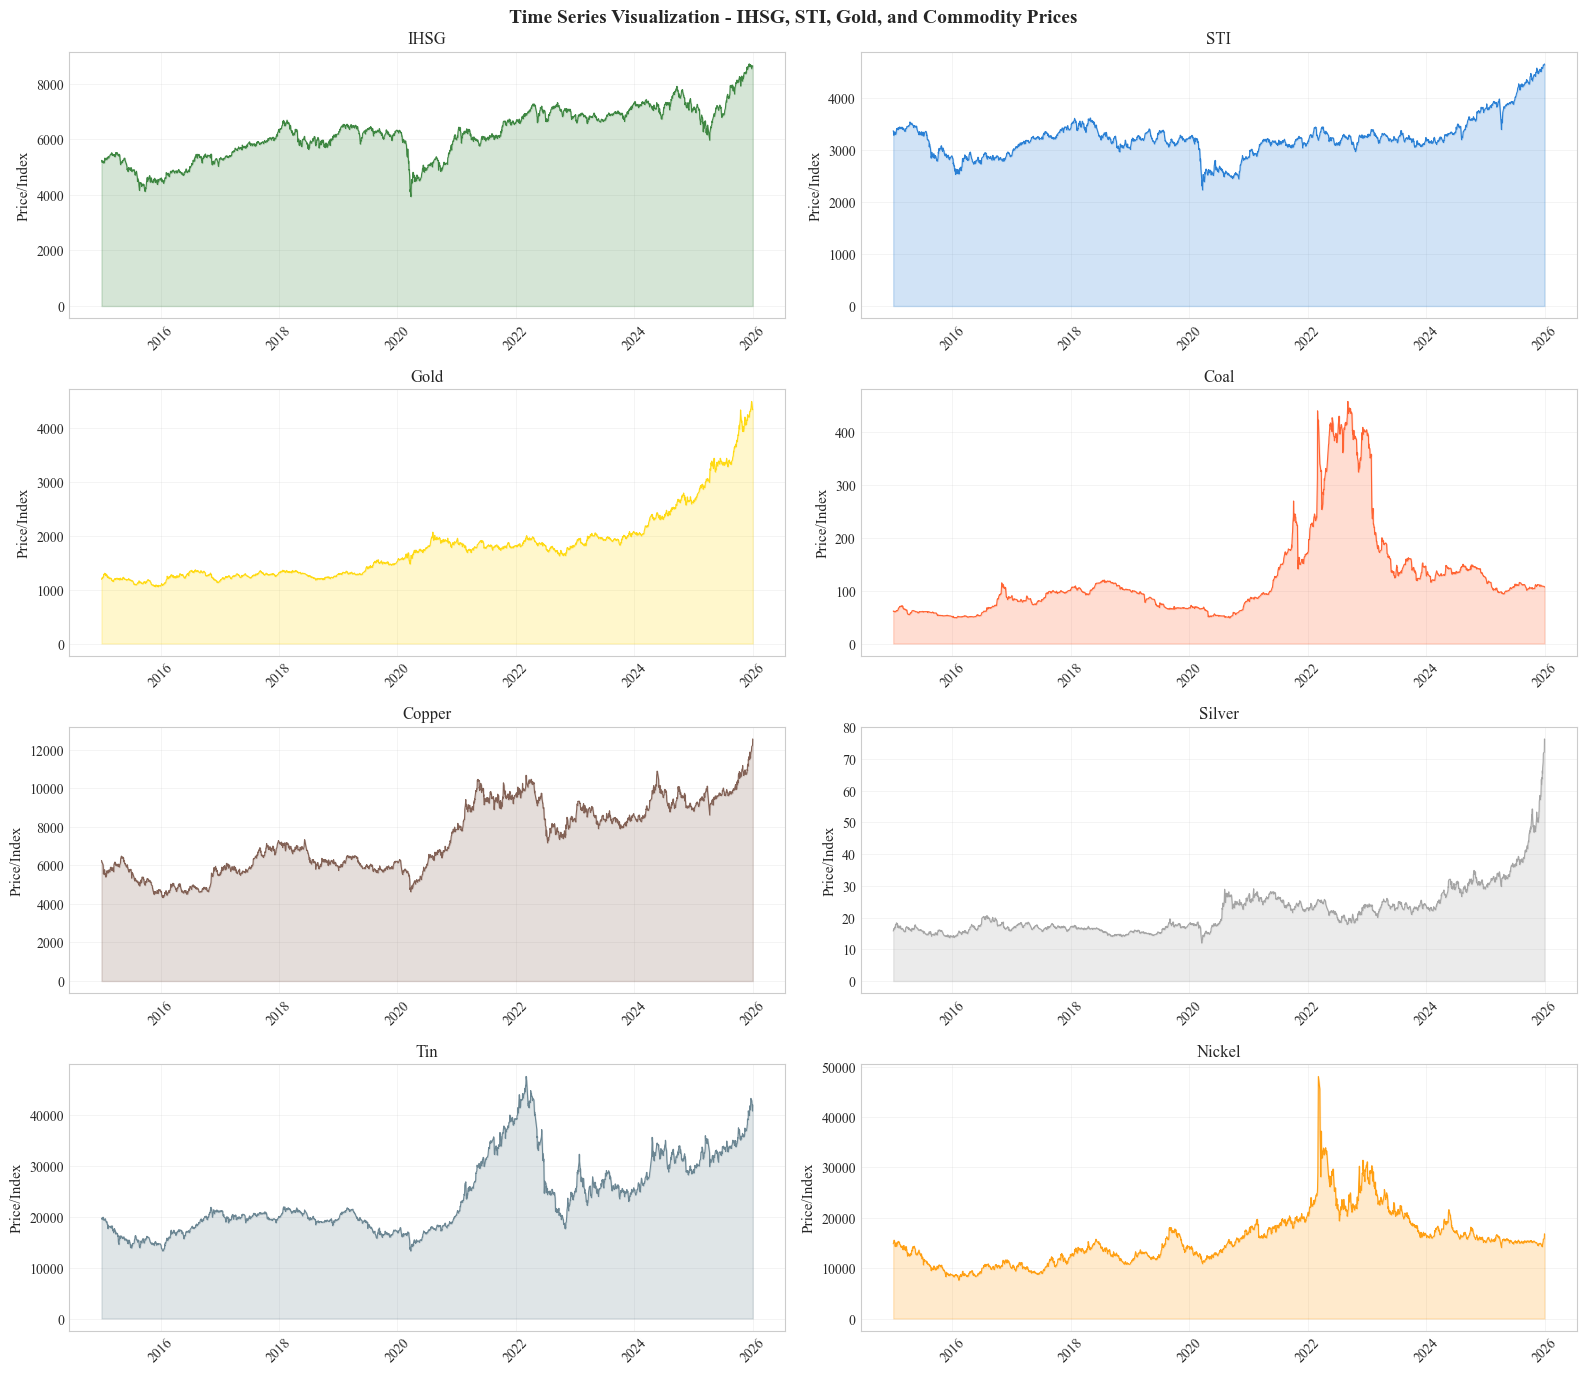

Figure saved: model2-figure/model2_eda_timeseries.png (300 DPI)


In [43]:
# Visualization: Time series plots with thesis colors
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
fig.suptitle('Time Series Visualization - IHSG, STI, Gold, and Commodity Prices', fontsize=14, fontweight='bold')

# Define colors from thesis palette (Gold added)
plot_config = [
    ('IHSG', COLORS['IHSG']),
    ('STI', COLORS['STI']),
    ('Gold', COLORS.get('Gold', '#FFD700')),  # Gold color
    ('Coal', COLORS['Coal']),
    ('Copper', COLORS['Copper']),
    ('Silver', COLORS['Silver']),
    ('Tin', COLORS['Tin']),
    ('Nickel', COLORS['Nickel'])
]

for idx, (col, color) in enumerate(plot_config):
    ax = axes[idx // 2, idx % 2]
    ax.plot(df['Date'], df[col], color=color, linewidth=0.8, alpha=0.9)
    ax.set_title(f'{col}', fontsize=12)
    ax.set_ylabel('Price/Index')
    ax.fill_between(df['Date'], df[col], alpha=0.2, color=color)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model2-figure/model2_eda_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_eda_timeseries.png (300 DPI)")

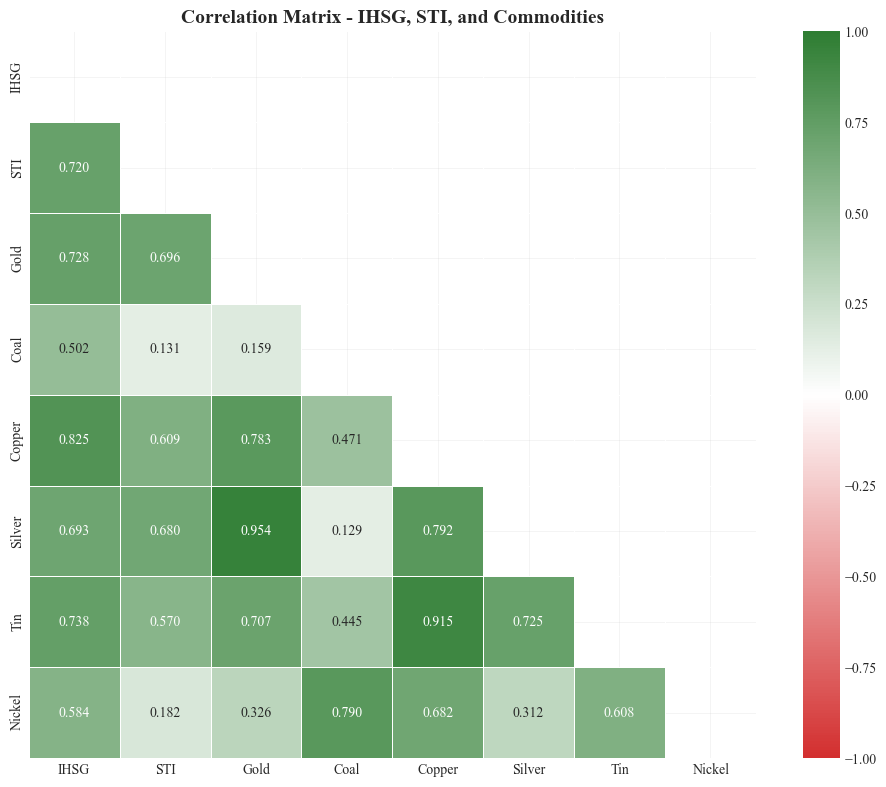

Figure saved: model2-figure/model2_correlation_matrix.png (300 DPI)

CORRELATION WITH IHSG
Copper          : +0.8253 (Strong Positive)
Tin             : +0.7376 (Strong Positive)
Gold            : +0.7279 (Strong Positive)
STI             : +0.7199 (Strong Positive)
Silver          : +0.6927 (Moderate Positive)
Nickel          : +0.5843 (Moderate Positive)
Coal            : +0.5023 (Moderate Positive)


In [44]:
# Correlation Analysis
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = df.drop('Date', axis=1).corr()

# Custom colormap: Green (positive with IHSG) to Red (negative)
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = ['#D32F2F', '#FFFFFF', '#2E7D32']  # Red - White - Green
custom_cmap = LinearSegmentedColormap.from_list('thesis_cmap', colors_cmap, N=256)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap=custom_cmap, 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 10}, vmin=-1, vmax=1)

ax.set_title('Correlation Matrix - IHSG, STI, and Commodities', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2-figure/model2_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_correlation_matrix.png (300 DPI)")

print("\n" + "="*60)
print("CORRELATION WITH IHSG")
print("="*60)
ihsg_corr = corr_matrix['IHSG'].drop('IHSG').sort_values(ascending=False)
for var, corr in ihsg_corr.items():
    direction = "Positive" if corr > 0 else "Negative"
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    print(f"{var:15} : {corr:+.4f} ({strength} {direction})")

## 4. Create Darts TimeSeries Objects

In [45]:
IHSG_series = TimeSeries.from_dataframe(df, time_col='Date', value_cols='IHSG', fill_missing_dates=False, freq='B')
COVAR_series = TimeSeries.from_dataframe(df, time_col='Date', value_cols=['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel'], fill_missing_dates=False, freq='B')


In [48]:
IHSG_series

,IHSG
Date,
2015-01-02,5242.769
2015-01-05,5219.995
2015-01-06,5169.060
2015-01-07,5207.118
2015-01-08,5211.828
...,...
2025-12-24,8537.911
2025-12-25,NaN
2025-12-26,NaN


In [49]:
ihsg_df = IHSG_series.to_dataframe()
covar_df = COVAR_series.to_dataframe()

In [50]:
ihsg_df = ihsg_df.interpolate(method='linear')
covar_df = covar_df.interpolate(method='linear')

In [51]:
ihsg_df

,IHSG
Date,
2015-01-02,5242.769000
2015-01-05,5219.995000
2015-01-06,5169.060000
2015-01-07,5207.118000
2015-01-08,5211.828000
...,...
2025-12-24,8537.911000
2025-12-25,8573.359333
2025-12-26,8608.807667


In [52]:
IHSG_series_filled = TimeSeries.from_dataframe(ihsg_df, value_cols='IHSG', fill_missing_dates=False, freq='B')
COVAR_series_filled = TimeSeries.from_dataframe(covar_df, value_cols=['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel'], fill_missing_dates=False, freq='B')

In [53]:
train_ratio = 0.8
split_point = int(len(IHSG_series_filled) * train_ratio)

ihsg_train = IHSG_series_filled[:split_point]
ihsg_test = IHSG_series_filled[split_point:]

covar_train = COVAR_series_filled[:split_point]
covar_test = COVAR_series_filled[split_point:]

<Axes: xlabel='Date'>

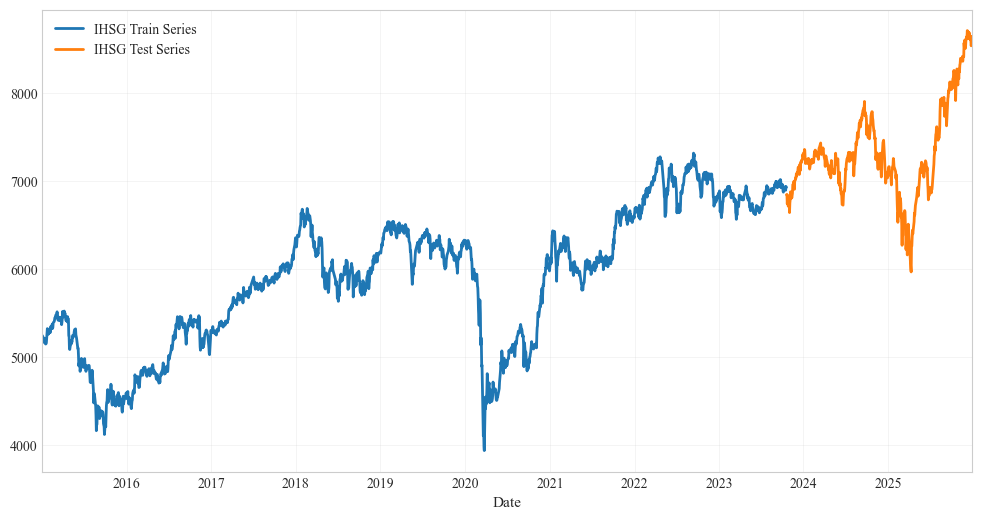

In [54]:
ihsg_train.plot(label='IHSG Train Series')
ihsg_test.plot(label='IHSG Test Series')

In [55]:
IHSG_series_filled

,IHSG
Date,
2015-01-02,5242.769000
2015-01-05,5219.995000
2015-01-06,5169.060000
2015-01-07,5207.118000
2015-01-08,5211.828000
...,...
2025-12-24,8537.911000
2025-12-25,8573.359333
2025-12-26,8608.807667


In [56]:
print("DARTS TIMESERIES")
print("="*60)
print(f"Target Series (IHSG):")
print(f"  - Start: {IHSG_series_filled.start_time()}")
print(f"  - End: {IHSG_series_filled.end_time()}")
print(f"  - Length: {len(IHSG_series_filled)} time steps")
print(f"  - Frequency: {IHSG_series_filled.freq}")
print(f"\nCovariates:")
print(f"  - Components: {COVAR_series_filled.components.tolist()}")
print(f"  - Length: {len(COVAR_series_filled)} time steps")

DARTS TIMESERIES
Target Series (IHSG):
  - Start: 2015-01-02 00:00:00
  - End: 2025-12-30 00:00:00
  - Length: 2868 time steps
  - Frequency: <BusinessDay>

Covariates:
  - Components: ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']
  - Length: 2868 time steps


In [57]:
from darts.dataprocessing.transformers import Scaler

scaler_ihsg = Scaler(MinMaxScaler(feature_range=(-1, 1)))

ihsg_train_scaled = scaler_ihsg.fit_transform(ihsg_train)
ihsg_test_scaled = scaler_ihsg.transform(ihsg_test)

scaler_covar = Scaler(MinMaxScaler(feature_range=(-1, 1)))

covar_train_scaled = scaler_covar.fit_transform(covar_train)
covar_test_scaled = scaler_covar.transform(covar_test)

covar_full_scaled = covar_train_scaled.append(covar_test_scaled)

# =====================================================
# VERIFIKASI TIDAK ADA LEAKAGE
# =====================================================
print("="*60)
print("DATA LEAKAGE CHECK")
print("="*60)
print(f"Train Target: {ihsg_train_scaled.start_time()} → {ihsg_train_scaled.end_time()}")
print(f"Train Cov:    {covar_train_scaled.start_time()} → {covar_train_scaled.end_time()}")
print(f"Test Target:  {ihsg_test_scaled.start_time()} → {ihsg_test_scaled.end_time()}")
print(f"Test Cov:     {covar_test_scaled.start_time()} → {covar_test_scaled.end_time()}")

# Pastikan train periods match
assert ihsg_train_scaled.end_time() == covar_train_scaled.end_time(), \
    "ERROR: Train target dan covariates tidak sinkron!"
print("\n✓ No data leakage detected in split")

DATA LEAKAGE CHECK
Train Target: 2015-01-02 00:00:00 → 2023-10-18 00:00:00
Train Cov:    2015-01-02 00:00:00 → 2023-10-18 00:00:00
Test Target:  2023-10-19 00:00:00 → 2025-12-30 00:00:00
Test Cov:     2023-10-19 00:00:00 → 2025-12-30 00:00:00

✓ No data leakage detected in split


## 5. Train/Test Split and Scaling

In [58]:
print("DARTS TIMESERIES")
print("="*60)
print(f"Target Series (IHSG):")
print(f"  - Start: {IHSG_series.start_time()}")
print(f"  - End: {IHSG_series.end_time()}")
print(f"  - Length: {len(IHSG_series)} time steps")
print(f"  - Frequency: {IHSG_series.freq}")
print(f"\nCovariates:")
print(f"  - Components: {COVAR_series.components.tolist()}")
print(f"  - Length: {len(COVAR_series)} time steps")

DARTS TIMESERIES
Target Series (IHSG):
  - Start: 2015-01-02 00:00:00
  - End: 2025-12-30 00:00:00
  - Length: 2868 time steps
  - Frequency: <BusinessDay>

Covariates:
  - Components: ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']
  - Length: 2868 time steps


## 6. Hyperparameter Tuning with GridSearch

In [59]:
OUTPUT_CHUNK_LENGTH = 1

# hyperparameter tuning gridsearch

param_grid = {
    'lags': [1, 3, 6, 12],
    'lags_past_covariates': [1, 3, 6, 12],       
    'n_estimators': [50, 100, 200],           
    'max_depth': [3, 5, 7, None],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],        
}
    
print("\nGridSearch Parameters:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to evaluate: {total_combinations}")



GridSearch Parameters:
  lags: [1, 3, 6, 12]
  lags_past_covariates: [1, 3, 6, 12]
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 7, None]
  max_features: [None, 'sqrt', 'log2']
  bootstrap: [True, False]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]

Total combinations to evaluate: 10368


In [ ]:
best_model, best_params, best_score = RandomForestModel.gridsearch(
    parameters=param_grid,
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    val_series=ihsg_test_scaled,
    metric=mape,
    verbose=True,
    n_jobs=-1,
    n_random_samples=200
)

print("\n" + "="*60)
print("GRIDSEARCH RESULTS")
print("="*60)
print(f"Best MAPE Score: {best_score:.4f}%")
print(f"\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

gridsearch:   0%|          | 0/200 [00:00<?, ?it/s]

## 7. Train Best Model and Generate Predictions

In [26]:
final_model = RandomForestModel(
    lags=best_params['lags'],
    lags_past_covariates=best_params['lags_past_covariates'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

In [27]:
final_model.fit(
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)

RandomForestModel(lags=1, lags_past_covariates=3, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, n_estimators=100, max_depth=None, multi_models=True, use_static_covariates=True, random_state=42, max_features=None, bootstrap=False, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)

In [28]:
forecast = final_model.predict(
    n=len(ihsg_test_scaled),
    past_covariates=covar_full_scaled
)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [29]:
from darts.metrics import rmse, mae, mape, smape, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Inverse transform to original scale
forecast_original = scaler_ihsg.inverse_transform(forecast)
test_original = scaler_ihsg.inverse_transform(ihsg_test_scaled)

print("="*60)
print("MODEL PERFORMANCE METRICS (Original Scale)")
print("="*60)

# Calculate metrics
metrics = {
    'RMSE': rmse(test_original, forecast_original),
    'MAE': mae(test_original, forecast_original),
    'MAPE': mape(test_original, forecast_original),
    'sMAPE': smape(test_original, forecast_original),
    'R²': r2_score(test_original, forecast_original)
}

for metric, value in metrics.items():
    print(f"{metric:8s}: {value:.4f}")

MODEL PERFORMANCE METRICS (Original Scale)
RMSE    : 618.7716
MAE     : 455.9865
MAPE    : 5.9641
sMAPE   : 6.2147
R²      : -0.3744


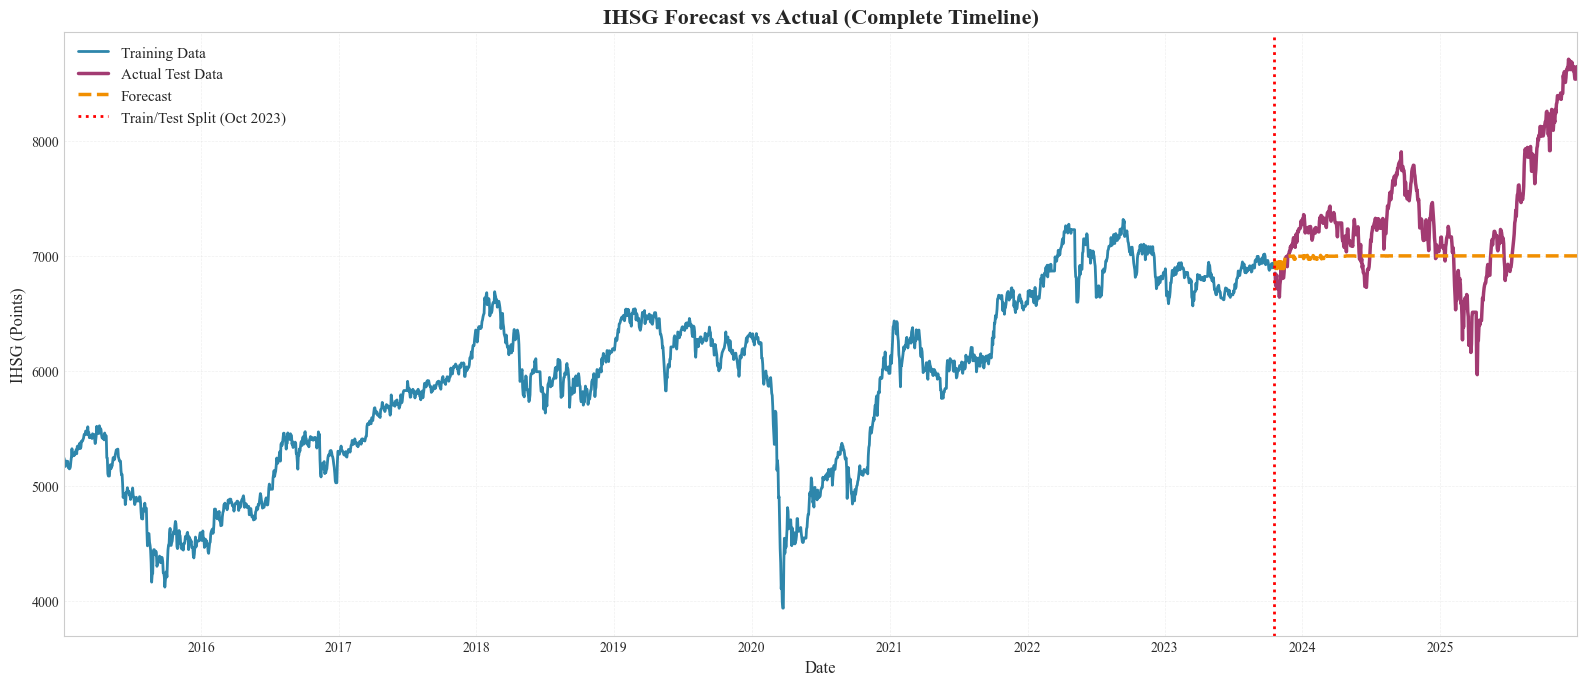

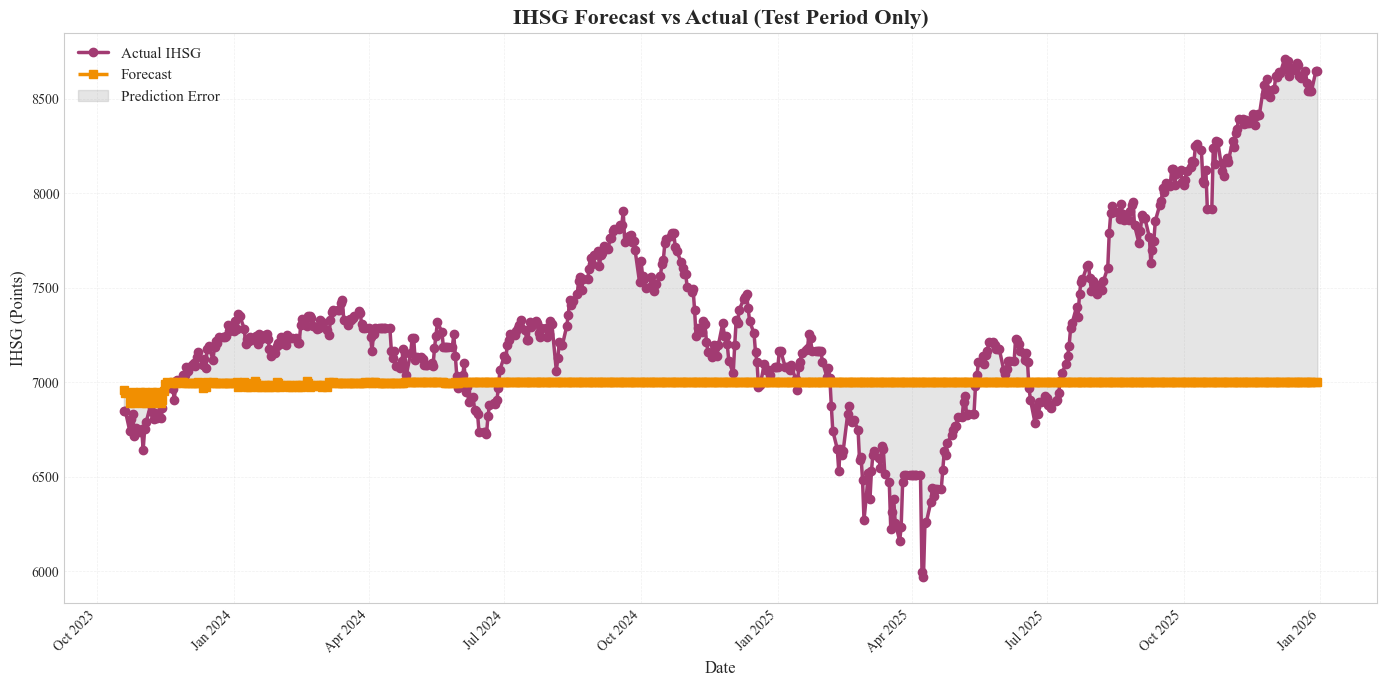

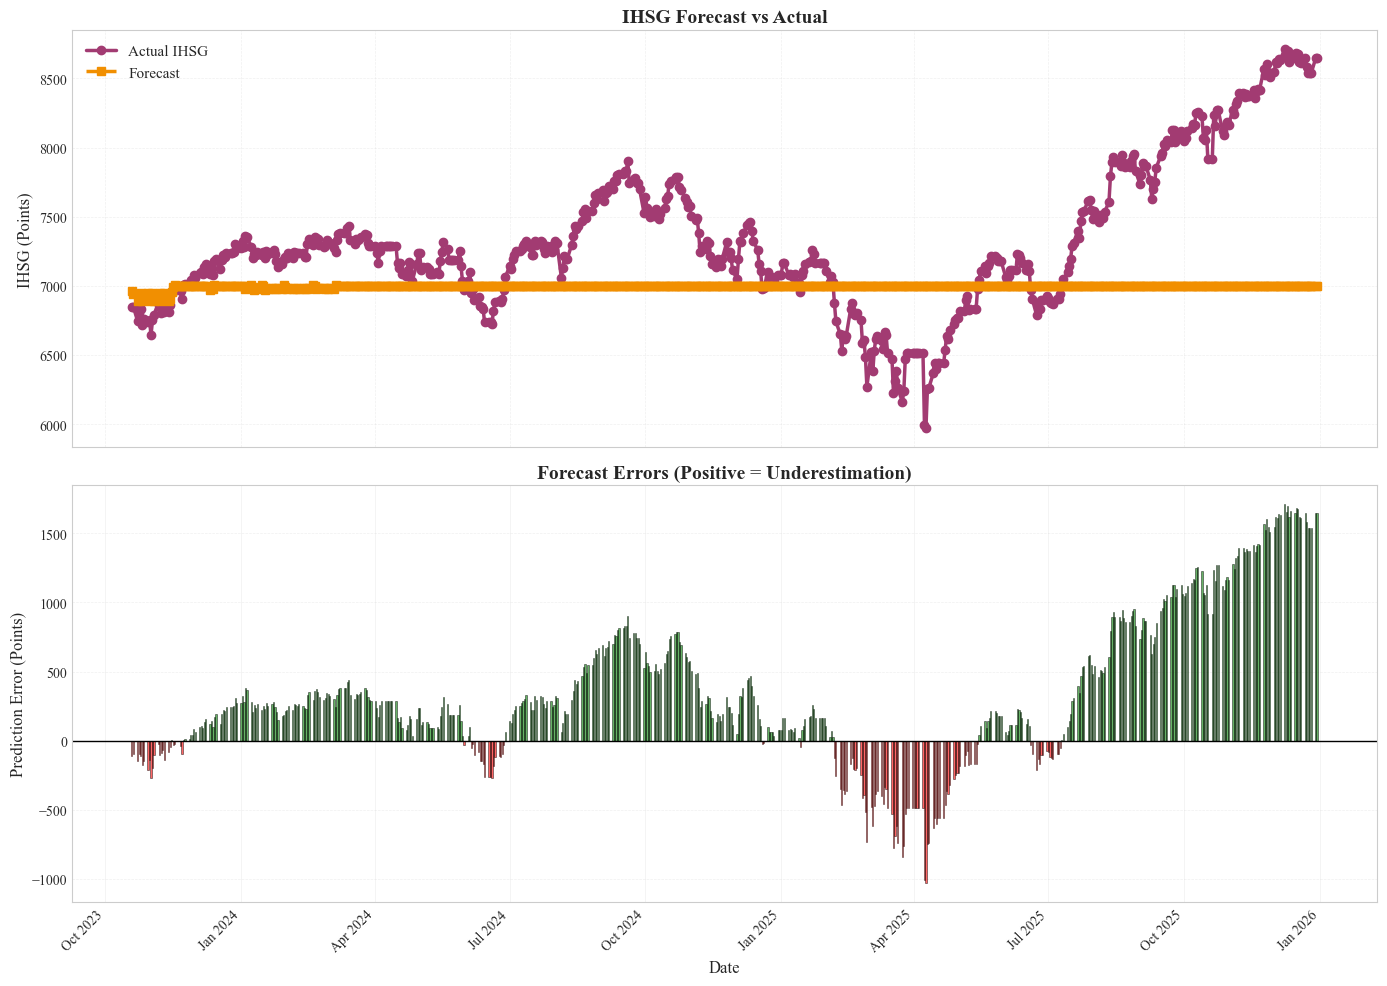

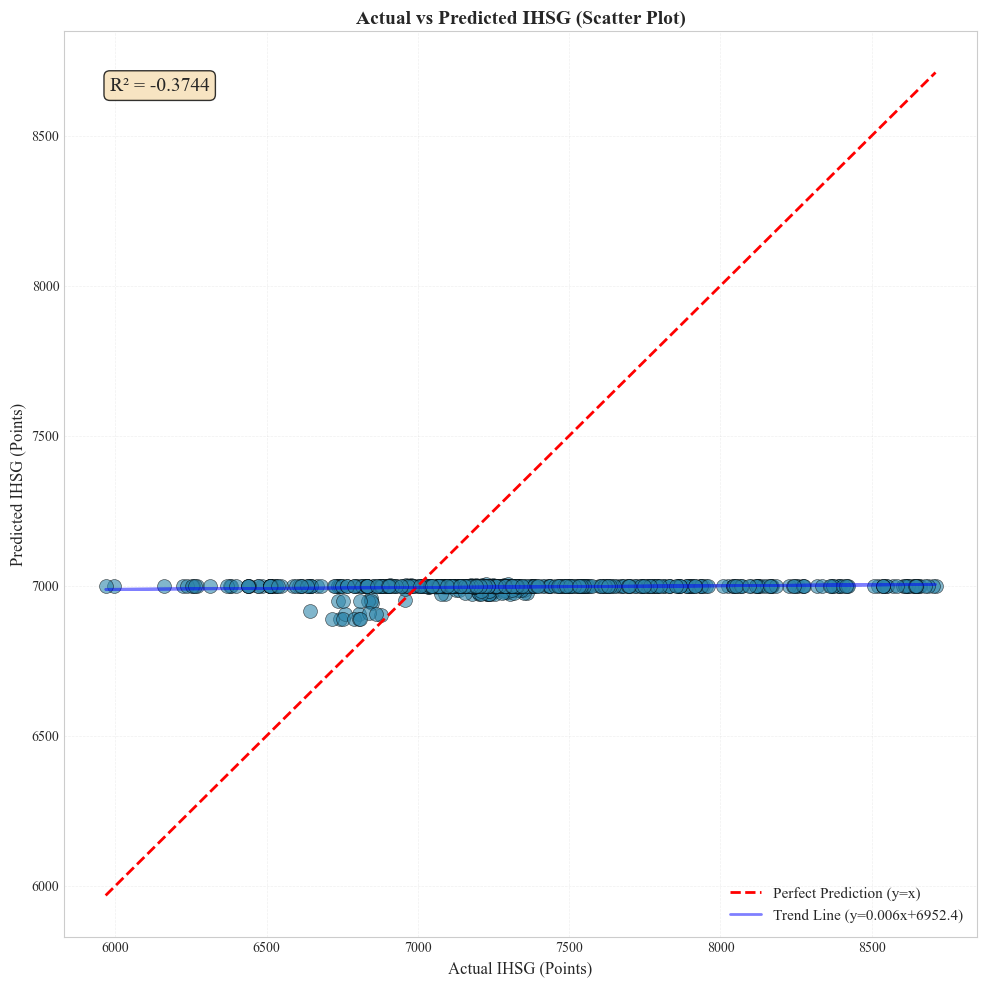

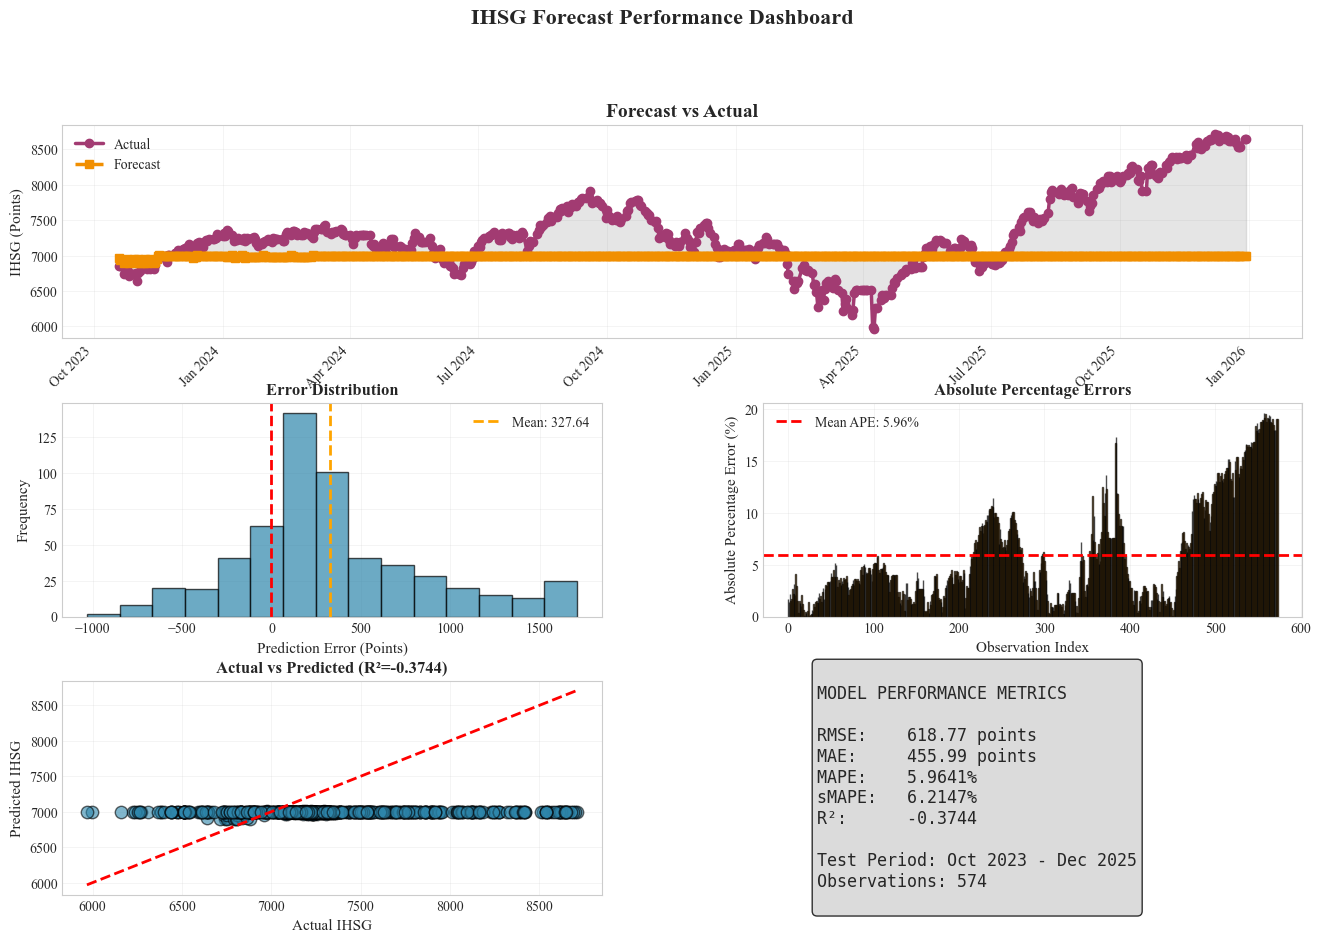


FORECAST SUMMARY STATISTICS
Test Period:        October 2023 to December 2025
Number of Points:   574

Actual IHSG:
  Mean:             7323.78
  Min:              5967.99
  Max:              8710.69
  Std Dev:          527.81

Forecast IHSG:
  Mean:             6996.14
  Min:              6890.01
  Max:              7005.29
  Std Dev:          16.33

Prediction Errors:
  Mean Error:       327.64 points
  Mean Abs Error:   455.99 points
  Max Overest:      -1032.75 points
  Max Underest:     1709.96 points


In [30]:
# =====================================================
# FORECAST VS ACTUAL VISUALIZATION (Original Scale)
# =====================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Ensure we have the data
forecast_original = scaler_ihsg.inverse_transform(forecast)
test_original = scaler_ihsg.inverse_transform(ihsg_test_scaled)
train_original = scaler_ihsg.inverse_transform(ihsg_train_scaled)

# =====================================================
# PLOT 1: Complete Timeline with Train/Test/Forecast
# =====================================================
plt.figure(figsize=(16, 7))

# Plot train data
train_original.plot(label="Training Data", color='#2E86AB', linewidth=2)

# Plot actual test data
test_original.plot(label="Actual Test Data", color='#A23B72', linewidth=2.5)

# Plot forecast
forecast_original.plot(label="Forecast", color='#F18F01', linewidth=2.5, linestyle='--')

# Add vertical line at train/test split
split_date = train_original.end_time()
plt.axvline(x=split_date, color='red', linestyle=':', linewidth=2, 
            label=f'Train/Test Split ({split_date.strftime("%b %Y")})')

# Formatting
plt.title('IHSG Forecast vs Actual (Complete Timeline)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# =====================================================
# PLOT 2: Test Period Only (Zoomed In)
# =====================================================
plt.figure(figsize=(14, 7))

# Plot actual and forecast
test_dates = test_original.time_index
actual_values = test_original.values().flatten()
forecast_values = forecast_original.values().flatten()

plt.plot(test_dates, actual_values, marker='o', markersize=6, 
         linewidth=2.5, color='#A23B72', label='Actual IHSG', linestyle='-')
plt.plot(test_dates, forecast_values, marker='s', markersize=6, 
         linewidth=2.5, color='#F18F01', label='Forecast', linestyle='--')

# Fill between to show error
plt.fill_between(test_dates, actual_values, forecast_values, 
                 alpha=0.2, color='gray', label='Prediction Error')

# Formatting
plt.title('IHSG Forecast vs Actual (Test Period Only)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

# Format x-axis dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# =====================================================
# PLOT 3: Side-by-Side Comparison with Error Bars
# =====================================================
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Subplot 1: Actual vs Forecast
axes[0].plot(test_dates, actual_values, marker='o', markersize=6,
             linewidth=2.5, color='#A23B72', label='Actual IHSG')
axes[0].plot(test_dates, forecast_values, marker='s', markersize=6,
             linewidth=2.5, color='#F18F01', label='Forecast', linestyle='--')
axes[0].set_ylabel('IHSG (Points)', fontsize=12)
axes[0].set_title('IHSG Forecast vs Actual', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Subplot 2: Absolute Errors
errors = actual_values - forecast_values
axes[1].bar(test_dates, errors, color=['green' if e > 0 else 'red' for e in errors],
            alpha=0.6, edgecolor='black', linewidth=0.5)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_ylabel('Prediction Error (Points)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_title('Forecast Errors (Positive = Underestimation)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', axis='y')

# Format x-axis
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# =====================================================
# PLOT 4: Scatter Plot (Actual vs Predicted)
# =====================================================
plt.figure(figsize=(10, 10))

# Scatter plot
plt.scatter(actual_values, forecast_values, alpha=0.6, s=100, 
            color='#2E86AB', edgecolors='black', linewidth=0.5)

# Perfect prediction line (y=x)
min_val = min(actual_values.min(), forecast_values.min())
max_val = max(actual_values.max(), forecast_values.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
         label='Perfect Prediction (y=x)')

# Add trend line
z = np.polyfit(actual_values, forecast_values, 1)
p = np.poly1d(z)
plt.plot(actual_values, p(actual_values), "b-", linewidth=2, alpha=0.5,
         label=f'Trend Line (y={z[0]:.3f}x+{z[1]:.1f})')

# Add R² annotation
from sklearn.metrics import r2_score as sklearn_r2
r2 = sklearn_r2(actual_values, forecast_values)
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', 
         facecolor='wheat', alpha=0.8))

# Formatting
plt.xlabel('Actual IHSG (Points)', fontsize=12)
plt.ylabel('Predicted IHSG (Points)', fontsize=12)
plt.title('Actual vs Predicted IHSG (Scatter Plot)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# =====================================================
# PLOT 5: Performance Summary Dashboard
# =====================================================
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Time Series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(test_dates, actual_values, marker='o', linewidth=2.5, 
         color='#A23B72', label='Actual')
ax1.plot(test_dates, forecast_values, marker='s', linewidth=2.5, 
         color='#F18F01', label='Forecast', linestyle='--')
ax1.fill_between(test_dates, actual_values, forecast_values, 
                 alpha=0.2, color='gray')
ax1.set_title('Forecast vs Actual', fontsize=14, fontweight='bold')
ax1.set_ylabel('IHSG (Points)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Error Distribution
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(errors, bins=15, edgecolor='black', alpha=0.7, color='#2E86AB')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.axvline(x=errors.mean(), color='orange', linestyle='--', linewidth=2,
            label=f'Mean: {errors.mean():.2f}')
ax2.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Prediction Error (Points)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Absolute Percentage Errors
ax3 = fig.add_subplot(gs[1, 1])
percentage_errors = np.abs(errors / actual_values) * 100
ax3.bar(range(len(percentage_errors)), percentage_errors, 
        color='#F18F01', alpha=0.7, edgecolor='black')
ax3.axhline(y=percentage_errors.mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean APE: {percentage_errors.mean():.2f}%')
ax3.set_title('Absolute Percentage Errors', fontsize=12, fontweight='bold')
ax3.set_xlabel('Observation Index')
ax3.set_ylabel('Absolute Percentage Error (%)')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Scatter Plot
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(actual_values, forecast_values, alpha=0.6, s=80, 
            color='#2E86AB', edgecolors='black')
min_val = min(actual_values.min(), forecast_values.min())
max_val = max(actual_values.max(), forecast_values.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax4.set_title(f'Actual vs Predicted (R²={r2:.4f})', fontsize=12, fontweight='bold')
ax4.set_xlabel('Actual IHSG')
ax4.set_ylabel('Predicted IHSG')
ax4.grid(True, alpha=0.3)

# Plot 5: Metrics Table
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

# Calculate metrics
from darts.metrics import rmse, mae, mape, smape
metrics_text = f"""
MODEL PERFORMANCE METRICS

RMSE:    {rmse(test_original, forecast_original):.2f} points
MAE:     {mae(test_original, forecast_original):.2f} points
MAPE:    {mape(test_original, forecast_original):.4f}%
sMAPE:   {smape(test_original, forecast_original):.4f}%
R²:      {r2:.4f}

Test Period: {test_dates[0].strftime('%b %Y')} - {test_dates[-1].strftime('%b %Y')}
Observations: {len(test_dates)}
"""

ax5.text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', 
         facecolor='lightgray', alpha=0.8))

plt.suptitle('IHSG Forecast Performance Dashboard', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =====================================================
# Print Summary Statistics
# =====================================================
print("\n" + "="*70)
print("FORECAST SUMMARY STATISTICS")
print("="*70)
print(f"Test Period:        {test_dates[0].strftime('%B %Y')} to {test_dates[-1].strftime('%B %Y')}")
print(f"Number of Points:   {len(test_dates)}")
print(f"\nActual IHSG:")
print(f"  Mean:             {actual_values.mean():.2f}")
print(f"  Min:              {actual_values.min():.2f}")
print(f"  Max:              {actual_values.max():.2f}")
print(f"  Std Dev:          {actual_values.std():.2f}")
print(f"\nForecast IHSG:")
print(f"  Mean:             {forecast_values.mean():.2f}")
print(f"  Min:              {forecast_values.min():.2f}")
print(f"  Max:              {forecast_values.max():.2f}")
print(f"  Std Dev:          {forecast_values.std():.2f}")
print(f"\nPrediction Errors:")
print(f"  Mean Error:       {errors.mean():.2f} points")
print(f"  Mean Abs Error:   {np.abs(errors).mean():.2f} points")
print(f"  Max Overest:      {errors.min():.2f} points")
print(f"  Max Underest:     {errors.max():.2f} points")

In [33]:
forecast_original.head()

,IHSG
Date,
2023-10-19,6960.66958
2023-10-20,6942.67615
2023-10-23,6890.61080
2023-10-24,6906.08583
2023-10-25,6948.49792


DIAGNOSTIC ANALYSIS: FLAT PREDICTIONS

Prediction Statistics:
  First 10 predictions: [6960.66958 6942.67615 6890.6108  6906.08583 6948.49792 6890.30819
 6906.86101 6948.49792 6890.91341 6915.30864]
  Last 10 predictions:  [7000.73732 7000.73732 7000.73732 7000.73732 7000.73732 7000.73732
 7000.73732 7000.73732 7000.73732 7000.73732]
  Unique values:        108
  Total predictions:    574

⚠️ Predictions become constant starting at index: 44
   Date: 2023-12-20 00:00:00
   Constant value: 6997.41


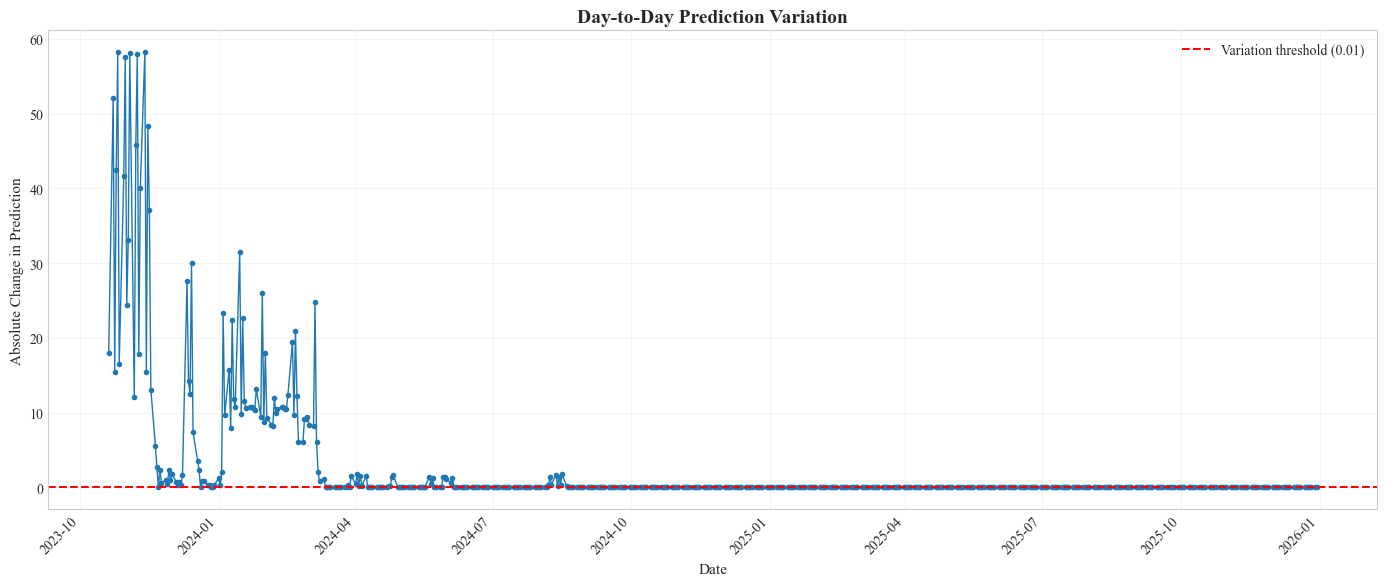

In [34]:
# =====================================================
# DIAGNOSTIC: Analyze Prediction Patterns
# =====================================================
print("="*70)
print("DIAGNOSTIC ANALYSIS: FLAT PREDICTIONS")
print("="*70)

# Check prediction values
pred_values = forecast_original.values().flatten()

print(f"\nPrediction Statistics:")
print(f"  First 10 predictions: {pred_values[:10]}")
print(f"  Last 10 predictions:  {pred_values[-10:]}")
print(f"  Unique values:        {len(np.unique(pred_values))}")
print(f"  Total predictions:    {len(pred_values)}")

# Check where predictions become constant
diffs = np.abs(np.diff(pred_values))
constant_threshold = 0.01  # Values changing less than 0.01

# Find where predictions stop varying
varying_mask = diffs > constant_threshold
if not varying_mask.all():
    first_constant_idx = np.where(~varying_mask)[0][0] + 1
    print(f"\n⚠️ Predictions become constant starting at index: {first_constant_idx}")
    print(f"   Date: {test_original.time_index[first_constant_idx]}")
    print(f"   Constant value: {pred_values[first_constant_idx]:.2f}")
else:
    print(f"\n✓ Predictions vary throughout the test period")

# Visualize prediction variance over time
plt.figure(figsize=(14, 6))
plt.plot(test_original.time_index[1:], diffs, marker='o', markersize=3, linewidth=1)
plt.axhline(y=constant_threshold, color='r', linestyle='--', 
            label=f'Variation threshold ({constant_threshold})')
plt.title('Day-to-Day Prediction Variation', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Absolute Change in Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
# =====================================================
# DEEP DIVE INVESTIGATION
# =====================================================
print("="*70)
print("DEEP DIVE: Why Predictions Stop at Dec 20, 2023")
print("="*70)

# Find the problematic date
problematic_date = pd.Timestamp('2023-12-20')
problematic_idx_in_df = df[df['Date'] == problematic_date].index

print(f"\nProblematic Date: {problematic_date}")
print(f"Index in original df: {problematic_idx_in_df.values if len(problematic_idx_in_df) > 0 else 'Not found'}")

# =====================================================
# Check Data Around Problematic Date
# =====================================================
print("\n" + "="*70)
print("DATA INSPECTION AROUND DEC 20, 2023")
print("="*70)

# Get data window around the problem
if len(problematic_idx_in_df) > 0:
    idx = problematic_idx_in_df[0]
    window_start = max(0, idx - 10)
    window_end = min(len(df), idx + 20)
    
    window_df = df.iloc[window_start:window_end].copy()
    
    print("\nData window (10 days before to 20 days after):")
    print(window_df[['Date', 'IHSG', 'STI', 'Gold', 'Coal', 'Copper', 'Nickel']].to_string(index=False))
    
    # Check for missing values
    print("\n" + "="*70)
    print("MISSING VALUES IN THIS WINDOW")
    print("="*70)
    missing_in_window = window_df.isnull().sum()
    for col, count in missing_in_window.items():
        if count > 0:
            print(f"  {col:<15}: {count:>3} missing values")
    
    # Check for constant values
    print("\n" + "="*70)
    print("CHECKING FOR CONSTANT VALUES")
    print("="*70)
    for col in ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']:
        unique_vals = window_df[col].nunique()
        if unique_vals < 5:
            print(f"  ⚠️ {col:<15}: Only {unique_vals} unique values!")
            print(f"     Values: {window_df[col].unique()}")
        
    # Check day-to-day changes
    print("\n" + "="*70)
    print("DAY-TO-DAY CHANGES (Should NOT be zero)")
    print("="*70)
    
    changes = window_df[['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']].diff()
    zero_change_mask = (changes.abs().sum(axis=1) < 0.01)
    
    if zero_change_mask.any():
        print("\n⚠️ Days with ZERO change in ALL covariates (problem!):")
        zero_change_dates = window_df.loc[zero_change_mask, 'Date']
        for date in zero_change_dates:
            print(f"  {date}")
    else:
        print("✓ All days show some covariate variation")

# =====================================================
# Check ENTIRE Test Period for Data Quality
# =====================================================
print("\n" + "="*70)
print("FULL TEST PERIOD DATA QUALITY CHECK")
print("="*70)

# Get test period dates
test_start_date = ihsg_test.time_index[0]
test_end_date = ihsg_test.time_index[-1]

print(f"\nTest Period: {test_start_date} to {test_end_date}")

# Filter df to test period
df_test_period = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)].copy()

print(f"Total test days in df: {len(df_test_period)}")
print(f"Total test days in series: {len(ihsg_test)}")

# Check for missing data in test period
print("\n" + "="*70)
print("MISSING DATA IN TEST PERIOD")
print("="*70)

missing_test = df_test_period.isnull().sum()
for col, count in missing_test.items():
    if count > 0:
        pct = (count / len(df_test_period)) * 100
        print(f"  {col:<15}: {count:>4} ({pct:>5.1f}%)")
        
        # Show dates with missing values
        if col in ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']:
            missing_dates = df_test_period[df_test_period[col].isnull()]['Date']
            if len(missing_dates) > 0:
                print(f"     Missing dates: {missing_dates.min()} to {missing_dates.max()}")

# =====================================================
# Analyze Daily Changes Throughout Test Period
# =====================================================
print("\n" + "="*70)
print("COVARIATE VARIATION ANALYSIS")
print("="*70)

# Calculate changes
test_changes = df_test_period[['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']].diff()
test_changes['Date'] = df_test_period['Date'].values

# Find periods with no changes
no_change_threshold = 0.01
total_change_per_day = test_changes[['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']].abs().sum(axis=1)
static_days = total_change_per_day < no_change_threshold

if static_days.any():
    n_static = static_days.sum()
    print(f"\n⚠️ Found {n_static} days with near-zero covariate changes:")
    
    # Group consecutive static days
    static_dates = test_changes[static_days]['Date'].reset_index(drop=True)
    
    if len(static_dates) > 0:
        # Find runs of consecutive static days
        date_diffs = static_dates.diff()
        
        print(f"\n  First static day: {static_dates.iloc[0]}")
        print(f"  Last static day:  {static_dates.iloc[-1]}")
        
        # Show first few
        print(f"\n  Static dates (first 20):")
        for i, date in enumerate(static_dates[:20]):
            print(f"    {date}")
else:
    print("✓ All days show covariate variation")

# =====================================================
# Check Specific Covariates After Dec 20
# =====================================================
print("\n" + "="*70)
print("COVARIATE VALUES AFTER DEC 20, 2023")
print("="*70)

after_dec20 = df_test_period[df_test_period['Date'] >= '2023-12-20'].copy()

if len(after_dec20) > 0:
    print(f"\nRows after Dec 20: {len(after_dec20)}")
    
    # Check each covariate
    for col in ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']:
        unique_vals = after_dec20[col].nunique()
        
        if unique_vals == 1:
            print(f"\n❌ {col}: CONSTANT VALUE!")
            print(f"   Value: {after_dec20[col].iloc[0]}")
        elif unique_vals < 10:
            print(f"\n⚠️ {col}: Only {unique_vals} unique values (suspicious)")
            print(f"   Range: {after_dec20[col].min():.2f} to {after_dec20[col].max():.2f}")
        else:
            print(f"\n✓ {col}: {unique_vals} unique values (varying)")
    
    # Show actual data
    print("\n" + "="*70)
    print("ACTUAL VALUES AFTER DEC 20 (first 30 rows)")
    print("="*70)
    print(after_dec20.head(30)[['Date', 'IHSG', 'STI', 'Gold', 'Coal', 'Copper']].to_string(index=False))

# =====================================================
# Check Forward Fill Impact
# =====================================================
print("\n" + "="*70)
print("FORWARD FILL IMPACT ANALYSIS")
print("="*70)

# Load original data WITHOUT forward fill to compare
print("\nComparing BEFORE and AFTER forward fill...")

# Original series (before ffill)
ihsg_original = IHSG_series.to_dataframe()
covar_original = COVAR_series.to_dataframe()

# After ffill
ihsg_after_ffill = IHSG_series_filled.to_dataframe()
covar_after_ffill = COVAR_series_filled.to_dataframe()

print(f"\nOriginal data NaN counts:")
print(covar_original.isnull().sum())

print(f"\nAfter ffill NaN counts:")
print(covar_after_ffill.isnull().sum())

# Check for runs of identical values (indicating ffill)
print("\n" + "="*70)
print("DETECTING FORWARD-FILLED SEGMENTS")
print("="*70)

for col in ['STI', 'Gold', 'Coal', 'Copper']:
    # Find consecutive identical values
    col_data = covar_after_ffill[col]
    is_duplicate = col_data == col_data.shift(1)
    
    # Find runs
    run_lengths = []
    current_run = 0
    
    for i, is_dup in enumerate(is_duplicate):
        if is_dup:
            current_run += 1
        else:
            if current_run > 0:
                run_lengths.append((i - current_run, current_run))
            current_run = 0
    
    # Find longest runs
    if run_lengths:
        longest_runs = sorted(run_lengths, key=lambda x: x[1], reverse=True)[:3]
        
        if longest_runs[0][1] > 10:  # If longest run > 10 days
            print(f"\n⚠️ {col}: Found {len(run_lengths)} forward-fill segments")
            print(f"   Longest run: {longest_runs[0][1]} consecutive days")
            run_start_idx = longest_runs[0][0]
            run_start_date = covar_after_ffill.index[run_start_idx]
            print(f"   Starting at: {run_start_date}")

# =====================================================
# SOLUTION RECOMMENDATION
# =====================================================
print("\n" + "="*70)
print("🎯 SOLUTION RECOMMENDATION")
print("="*70)

# Determine last good date
last_varying_idx = 44 - 1  # Index before predictions become constant
last_good_date = test_original.time_index[last_varying_idx]

print(f"\nBased on analysis:")
print(f"  ❌ Problem starts:     Dec 20, 2023")
print(f"  ✓ Last reliable date: {last_good_date}")
print(f"  📊 Usable test days:   {last_varying_idx + 1} out of {len(test_original)}")

print(f"\nRECOMMENDED ACTIONS:")
print(f"\n1. IMMEDIATE FIX - Truncate test set to reliable period:")
print(f"""
# Truncate to last reliable date
last_reliable_date = pd.Timestamp('{last_good_date}')

# Filter original dataframe
df_clean = df[df['Date'] <= last_reliable_date].copy()

print(f"Original data: {{len(df)}} rows")
print(f"Clean data:    {{len(df_clean)}} rows")
print(f"Removed:       {{len(df) - len(df_clean)}} unreliable rows")

# Re-run Model 2 with df_clean instead of df
""")

print(f"\n2. ROOT CAUSE FIX - Check your data source:")
print(f"   • Verify commodity price data after Dec 20, 2023")
print(f"   • Check if data provider has outages/issues for this period")
print(f"   • Consider alternative data sources for missing period")

print(f"\n3. ALTERNATIVE - Use interpolation instead of forward fill:")
print(f"""
# Instead of ffill, use interpolation
covar_df = covar_df.interpolate(method='linear', limit=5)  # Max 5 days gap
# or
covar_df = covar_df.interpolate(method='time')  # Time-based interpolation
""")

DEEP DIVE: Why Predictions Stop at Dec 20, 2023

Problematic Date: 2023-12-20 00:00:00
Index in original df: [2098]

DATA INSPECTION AROUND DEC 20, 2023

Data window (10 days before to 20 days after):
      Date     IHSG     STI    Gold   Coal  Copper  Nickel
2023-12-06 7087.395 3087.24 2025.55 140.45  8286.0   16218
2023-12-07 7134.623 3074.26 2028.47 148.75  8342.0   16508
2023-12-08 7159.598 3110.73 2004.67 151.00  8448.5   16806
2023-12-11 7088.785 3090.20 1981.95 152.50  8341.0   16607
2023-12-12 7125.307 3102.31 1979.54 146.25  8355.0   16520
2023-12-13 7075.341 3104.26 2027.74 146.25  8330.0   16468
2023-12-14 7176.016 3122.95 2036.36 145.50  8551.5   16972
2023-12-15 7190.988 3116.51 2019.62 145.25  8549.0   17150
2023-12-18 7119.525 3113.23 2027.19 144.75  8482.5   16502
2023-12-19 7187.846 3116.62 2040.35 145.25  8593.5   16747
2023-12-20 7219.667 3108.03 2031.39 144.25  8582.5   16854
2023-12-21 7209.619 3112.50 2045.95 145.25  8595.5   16888
2023-12-22 7237.519 3140.32 2053